In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px
import scipy
from scipy import integrate
from diel_tools import find_night, days_by_sunrise
import matplotlib.dates as mdates
from dateutil.parser import parse

In [3]:
df = pd.read_csv("PSD_mean_2022-10-20.csv")
df['date'] = pd.DatetimeIndex(df['date'].apply(lambda x: parse(x))).tz_convert('UTC')


FileNotFoundError: [Errno 2] No such file or directory: 'PSD_mean_2022-10-20.csv'

### Map of cruises that im using

In [59]:
map_df = df.copy()
map_df.date = pd.to_datetime(map_df.date)
# changes negative lon to postive value to plot better
map_df['lon'] = np.where(map_df['lon'] < 0, map_df['lon'] +360, map_df['lon'])
## samples are the data from cruises found wihtin this "box" of location in north pacific ocean
samples = map_df[(map_df['lon']>= 114) & (map_df['lon'] <= 242) & (map_df['lat'] >= 0)]
map_df_notnull = samples[samples.lon.notnull()]
map_df_avg = map_df_notnull.groupby([pd.Grouper(key = 'date', freq = '24H'), 'cruise']).mean().reset_index()
# i make figure here 
fig = px.scatter_geo(map_df_avg, lat = 'lat', lon = 'lon', color = 'cruise')
fig.show()

C:\Users\Krist\AppData\Local\Temp\ipykernel_14920\3203541437.py:8: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



### Plot of pro diel cycle in SCOPE_6

In [66]:
subset = df.loc[samples.index]

In [79]:
scope_6_pro

,cruise,date,pop,n_per_uL,c_per_uL,lat,lon,temp,salinity,par,c_quotas
26548,SCOPE_6,2015-07-25 00:00:00+00:00,prochloro,108.879389,4.835158,21.370393,-158.227993,27.217143,35.095714,1710.587857,0.044408
26552,SCOPE_6,2015-07-25 01:00:00+00:00,prochloro,118.620507,4.896587,21.524195,-158.309580,27.253500,35.117500,1872.756500,0.041279
26556,SCOPE_6,2015-07-25 03:00:00+00:00,prochloro,84.992478,4.224224,21.623643,-158.194900,26.688571,35.188571,1416.512857,0.049701
26560,SCOPE_6,2015-07-25 04:00:00+00:00,prochloro,85.348219,4.332430,21.610435,-158.126945,26.623500,35.180500,864.704500,0.050762
26564,SCOPE_6,2015-07-25 05:00:00+00:00,prochloro,95.938421,4.678521,21.685345,-158.084300,26.753000,35.205500,30.036000,0.048766
...,...,...,...,...,...,...,...,...,...,...,...
27500,SCOPE_6,2015-08-05 02:00:00+00:00,prochloro,125.393038,5.195718,22.790225,-156.963845,27.500500,35.020500,1747.372500,0.041435
27504,SCOPE_6,2015-08-05 03:00:00+00:00,prochloro,117.470822,5.534811,22.604930,-157.036010,27.500000,35.027000,1070.546500,0.047116
27508,SCOPE_6,2015-08-05 04:00:00+00:00,prochloro,120.002015,5.326479,22.418605,-157.106230,27.450500,35.069500,411.661500,0.044387
27512,SCOPE_6,2015-08-05 05:00:00+00:00,prochloro,129.215307,5.259567,22.238015,-157.171285,27.404000,35.055000,11.197500,0.040704


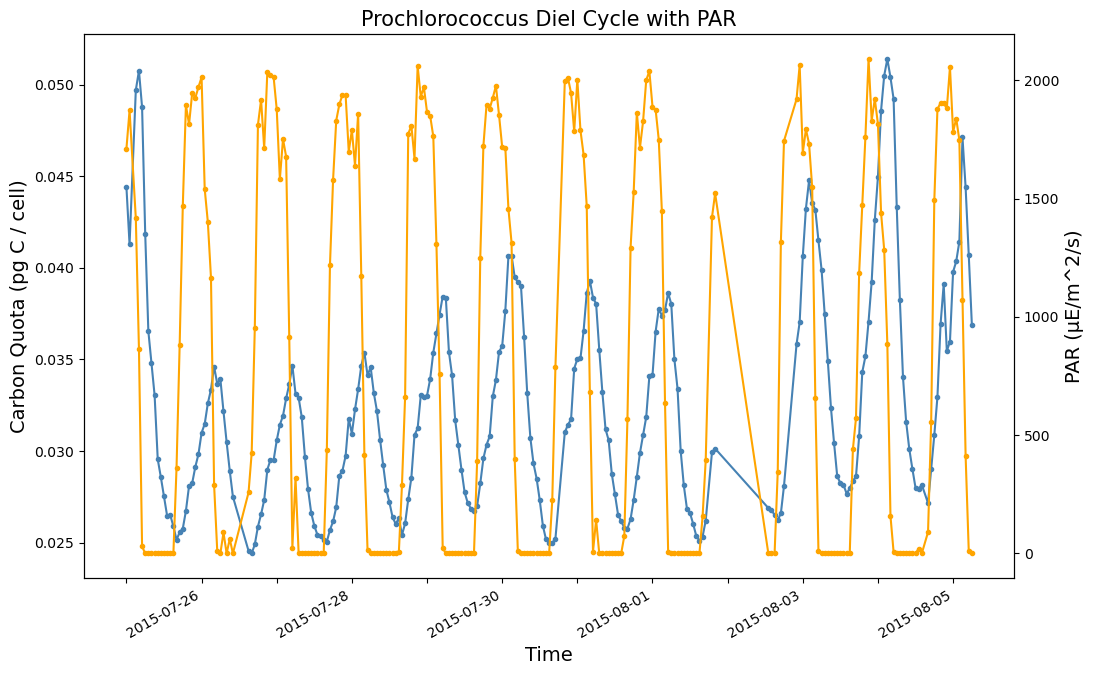

In [80]:
# figure making to give context why im looking at pro cell size (cell size changes everyday day bc diel cycle but i want to look at overall change in cell size)
# make figure of pro diel cycle 
df_pro = subset[subset['pop'] == 'prochloro']
# getting data from scope_6 and plotting
scope_6_pro = df_pro[df_pro['cruise'] == 'SCOPE_6']
# setting variables
x = scope_6_pro['date']
y = scope_6_pro['c_quotas']
y1 = scope_6_pro['par']
# plotting diel cycle from scope_6 for pro only
fig, ax = plt.subplots(sharey = True, sharex = True, nrows = 1, ncols = 1, figsize = (12, 8))
# plots carbon quota data
ax.plot(x, y, c='steelblue', marker = '.')
# makes secondary axis by sharing the the xaxis and creating yaxis
parax = ax.twinx()
# plots par on shared xaxis
parax.plot(x, y1, c = 'orange', marker = '.')
ax.set_xlabel('Time', fontsize = 14)
parax.set_ylabel('PAR (μE/m^2/s)', fontsize = 14)
ax.set_ylabel('Carbon Quota (pg C / cell)', fontsize = 14)
plt.title('Prochlorococcus Diel Cycle with PAR', fontsize = 15)

# shortens days into every other day for tick mark labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
#plt.savefig('fig2.png')


### Refining data in df to make find_night function work

In [72]:
df_change = subset.copy()
## filtering out the NaN val in lon column
df_change_notnull = df_change[df_change.lon.notnull()].reset_index()
## renamed date column to time for astral fucntion to work
df_change_notnull.rename(columns = {'date':'time'}, inplace = True)
df_night = find_night(df_change_notnull)

### Slicing out day and sunset to get "day"

In [73]:
## integrating par
def integrate_par(df):
    df['int_par'] = integrate.cumtrapz(y=df['par'], x=df['sec'],initial=0)
    return df

In [74]:
pro_cruises = df_night[df_night['pop'] == 'prochloro']
# im joining the 
pro_notnight = pro_cruises[pro_cruises['night'] != 'night']

##pro_join = pd.concat([pro_day, pro_sunset])
# here im trying to get rid of the NaN values in PAR now
real_pro = pro_notnight[pro_notnight.par.notnull()].reset_index()
epoch = pd.to_datetime('1970-01-01')
real_pro['sec'] = round((real_pro['time'].dt.tz_localize(None)-epoch).dt.total_seconds())
int_pro = real_pro.groupby([pd.Grouper(key='time', freq='24H'), 'cruise']).apply(integrate_par)
real_data = int_pro.groupby([pd.Grouper(key='time', freq='24H'), 'cruise']).agg({
    'c_quotas': 'mean',
    'int_par': 'sum',
    'lat': 'mean'
}).reset_index()

C:\Users\Krist\AppData\Local\Temp\ipykernel_14920\496470608.py:10: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [75]:
real_data[real_data['lat'] <0]

,time,cruise,c_quotas,int_par,lat


### Plotting PAR vs c_quotas using scipy... maybe

Text(0.5, 1.0, 'Prochlorococcus PAR vs Carbon Quota')

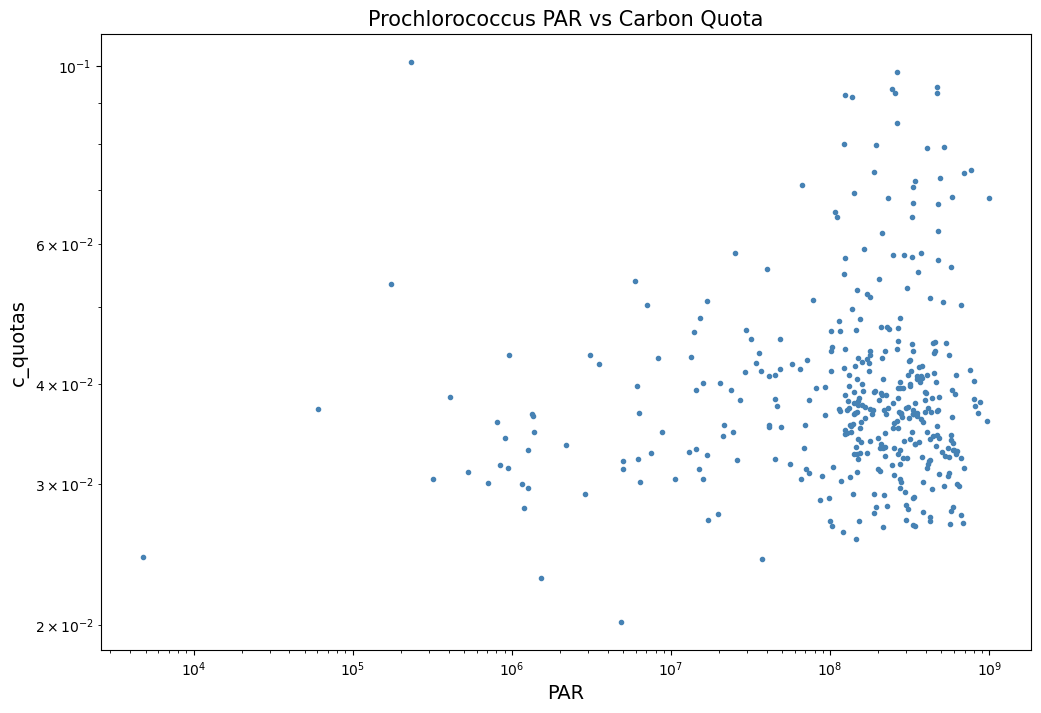

In [76]:
# setting variables
x = real_data['int_par']
y = real_data['c_quotas']

fig, ax = plt.subplots(sharey = True, sharex = True, nrows = 1, ncols = 1, figsize = (12, 8))
# plots carbon quota data
ax.scatter(x, y, c='steelblue', marker = '.')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('PAR', fontsize = 14)
ax.set_ylabel('c_quotas', fontsize = 14)
plt.title('Prochlorococcus PAR vs Carbon Quota', fontsize = 15)

In [82]:
px.scatter(real_data, x='int_par', y='c_quotas', color='lat', log_x = True, log_y = True, title='Carbon Quota Against Integreated PAR in Varying Latitudes', labels={
    'int_par': 'Integrated PAR (μE / m^2)',
    'c_quotas': 'Carbon Quota (pg C / cell)'
})